## Visualize pitch class features
  
This notebook shows how to load pre-computed features (predictions) and to generate the visualizations shown in Figure 5 of the paper.

&copy; Christof Weiss and Geoffroy Peeters, Télécom Paris 2021

In [1]:
import os
import sys
basepath = os.path.abspath(os.path.dirname(os.path.dirname('.')))
sys.path.append(basepath)
import numpy as np, os, scipy, scipy.spatial, matplotlib.pyplot as plt, IPython.display as ipd
from numba import jit
import librosa
import libfmp.b, libfmp.c3, libfmp.c5
import pandas as pd, pickle, re
from numba import jit
import torch.utils.data
import torch.nn as nn
import libdl.data_preprocessing
from libdl.data_loaders import dataset_context, dataset_context_segm
from libdl.nn_models import basic_cnn_segm_sigmoid, basic_cnn_segm_blank_logsoftmax
from libdl.data_preprocessing import compute_hopsize_cqt, compute_hcqt, compute_efficient_hcqt, compute_annotation_array_nooverlap

### Load precomputed chroma features and plot

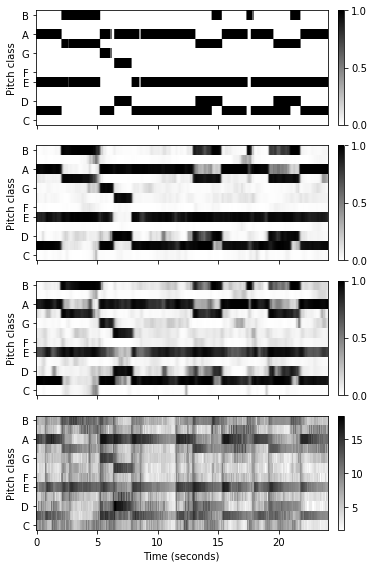

In [2]:
from matplotlib import gridspec

basedir_feat = os.path.join('predictions')

fs=22050
hopsize_hcqt=512
fs_hcqt = fs/hopsize_hcqt
Fs = 22050
N = 4096
H = 2048
H_input = 512
featrate_input = Fs/H_input
featrate_output = Fs/H
featrate_factor = int(featrate_input/featrate_output)

filenum_test = 206   # Schubert_D911-23_SC06.npy

start_sec = 26
show_sec = 50

feat_annot = np.load(os.path.join(basedir_feat, 'chromafeatures_annot_aligned_10-8Hz_soft.npz'))[str(filenum_test)]
feat_aligned = np.load(os.path.join(basedir_feat, 'chromafeatures_cnn_aligned_10-8Hz_soft.npz'))[str(filenum_test)]
feat_mctc = np.load(os.path.join(basedir_feat, 'chromafeatures_cnn_mctc_10-8Hz_soft.npz'))[str(filenum_test)]
feat_cqt = np.load(os.path.join(basedir_feat, 'chromafeaturesCQT_10-8Hz.npz'))[str(filenum_test)]

feat_annot = np.roll(feat_annot, 2, axis=0)
feat_aligned = np.roll(feat_aligned, 2, axis=0)
feat_mctc = np.roll(feat_mctc, 2, axis=0)
feat_cqt = np.roll(feat_cqt, 2, axis=0)

fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.02]}, figsize=(5.3, 8))


# Pitch class annotations
cfig, cax, cim = libfmp.b.plot_matrix(feat_annot[:, int(start_sec*featrate_output):int(show_sec*featrate_output)], ax=ax[0], Fs=featrate_output, cmap='gray_r', ylabel='Pitch class')
ax[0, 0].set_xlabel('')
ax[0, 0].set_yticks([0, 2, 4, 5, 7, 9, 11])
ax[0, 0].set_yticklabels(['C', 'D', 'E', 'F', 'G', 'A', 'B'], fontsize=10)
ax[0, 1].set_ylim([0, 1])
cbar = cim.colorbar
cbar.set_ticks(np.arange(0, 1.5, 0.5))
ax[0, 0].set_xticklabels([])

# Pitch class predictions of a model with strongly-aligned training (BCE loss)
cfig, cax, cim = libfmp.b.plot_matrix(feat_aligned[:, int(start_sec*featrate_output):int(show_sec*featrate_output)], Fs=featrate_output, ax=ax[1], cmap='gray_r', ylabel='Pitch class')
ax[1, 0].set_xlabel('')
ax[1, 0].set_yticks([0, 2, 4, 5, 7, 9, 11])
ax[1, 0].set_yticklabels(['C', 'D', 'E', 'F', 'G', 'A', 'B'], fontsize=10)
ax[1, 0].set_xticklabels([])
ax[1, 1].set_ylim([0, 1])
cbar = cim.colorbar
cbar.set_ticks(np.arange(0, 1.5, 0.5))

# Pitch class predictions of a model with weakly-aligned training (MCTC:WE loss)
cfig, cax, cim = libfmp.b.plot_matrix(feat_mctc[:, int(start_sec*featrate_output):int(show_sec*featrate_output)], Fs=featrate_output, ax=ax[2], cmap='gray_r', ylabel='Pitch class')
ax[2, 0].set_xlabel('')
ax[2, 0].set_yticks([0, 2, 4, 5, 7, 9, 11])
ax[2, 0].set_yticklabels(['C', 'D', 'E', 'F', 'G', 'A', 'B'], fontsize=10)
ax[2, 1].set_ylim([0, 1])
ax[2, 0].set_xticklabels([])
cbar = cim.colorbar
cbar.set_ticks(np.arange(0, 1.5, 0.5))

# Pitch class predictions extracted from a Constant-Q Transform (CQT)
cfig, cax, cim = libfmp.b.plot_matrix(feat_cqt[:, int(start_sec*featrate_output):int(show_sec*featrate_output)], Fs=featrate_output, ax=ax[3], cmap='gray_r', ylabel='Pitch class')
ax[3, 0].set_yticks([0, 2, 4, 5, 7, 9, 11])
ax[3, 0].set_yticklabels(['C', 'D', 'E', 'F', 'G', 'A', 'B'], fontsize=10)
ax[3, 0].set_xticklabels(['', '0', '5', '10', '15', '20'], fontsize=10)

plt.tight_layout()